In [17]:
import pandas as pd
from pandas_datareader import data
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from sklearn import svm
import seaborn as sns

In [2]:
start_date='2001-01-01'
end_date='2018-01-01'
goog_data=data.DataReader('GOOG','yahoo',start_date,end_date)

In [3]:
def create_classification_trading_condition(df):
    df["Open-Close"]=df.Open-df.Close
    df["High-Low"]=df.High-df.Low
    df.dropna(inplace=True)
    X=df[["Open-Close","High-Low"]]
    Y=np.where(df["Close"].shift(-1)>df["Close"],1,-1)#This keeps account of direction of price movement
    df["Target"]=Y
    return (X,Y)

def create_regression_trading_condition(df):
    df["Open-Close"]=df.Open-df.Close
    df["High-Low"]=df.High-df.Low
    df["Target"]=df["Close"].shift(-1)-df["Close"]
    df.dropna(inplace=True)
    X=df[["Open-Close","High-Low"]]
    Y=df["Target"]#This keeps account of direction as well as magnitude of price movement
#     X.drop(X.index[-1],inplace=True)
#     Y.dropna(inplace=True)
    return (X,Y)

def create_train_split_group(X,Y,split_ratio=0.8):
    return train_test_split(X,Y,shuffle=False,train_size=split_ratio)

# KNN

In [4]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

In [5]:
X,Y=create_classification_trading_condition(goog_data)
X_train,X_test,Y_train,Y_test=create_train_split_group(X,Y,split_ratio=0.8)

In [6]:
knn=KNeighborsClassifier(n_neighbors=15)
knn.fit(X_train, Y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=15, p=2,
                     weights='uniform')

In [7]:
accuracy_train = accuracy_score(Y_train, knn.predict(X_train))
accuracy_test = accuracy_score(Y_test, knn.predict(X_test))

In [8]:
# Predict the direction

goog_data['Predicted_Signal']=knn.predict(X)

In [9]:
def calculate_return(df,split_value,symbol):
    cum_goog_return=((1+df[split_value:][symbol+"_Returns"]).cumprod()-1)*100#Returns for period after X_train i.e. for X_test
    arr=[0]
    for i in range(len(df)):
        cond=(df["Predicted_Signal"].shift(1))[i]*(df["Target"].shift(1))[i]
        if cond<0:
            if df["Target"].shift(1)[i]>0:
                arr.append(-df[symbol+"_Returns"][i])
            else:
                arr.append(df[symbol+"_Returns"][i])
        elif cond>0:
            if df["Target"].shift(1)[i]>0:
                arr.append(df[symbol+"_Returns"][i])
            else:
                arr.append(-df[symbol+"_Returns"][i])
    df["Strategy_Returns"]=arr
    return cum_goog_return

def calculate_strategy_return(df, split_value, symbol):
    cum_strategy_return =((1+df[split_value:]['Strategy_Returns']).cumprod()-1) * 100
    return cum_strategy_return

def plot_chart(cum_symbol_return,cum_strategy_return,symbol):
    plt.figure(figsize=(16,6))
    plt.plot(cum_symbol_return, label=symbol+" Returns")
    plt.plot(cum_strategy_return, label='Strategy Returns')
    plt.axhline(y=0,color="k")
    plt.legend()

def sharpe_ratio(strategy_returns,symbol_returns):
    strategy_std=strategy_returns.std()
    risk_free_rate=0.02651826667614543 #Acc to SBI 6.91% per year
    sharpe=(strategy_returns-risk_free_rate)/strategy_std
    return sharpe.mean()

In [10]:
goog_data['GOOG_Returns']=np.log(goog_data['Close']/goog_data['Close'].shift(1))

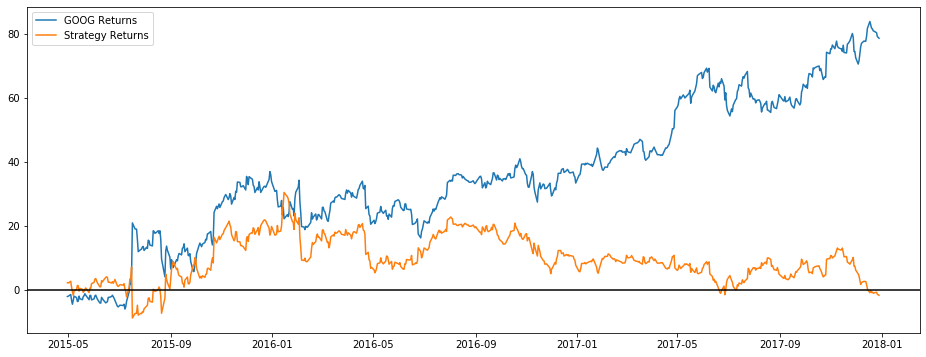

In [11]:
cum_goog_return=calculate_return(goog_data,split_value=len(X_train),symbol='GOOG')
cum_strategy_return=calculate_strategy_return(goog_data,split_value=len(X_train),symbol='GOOG')
plot_chart(cum_goog_return, cum_strategy_return,symbol='GOOG')

In [12]:
print("Sharpe Ratio is: "+str(sharpe_ratio(cum_strategy_return,cum_goog_return)))

Sharpe Ratio is: 1.370698181266878


# Support Vector Machine

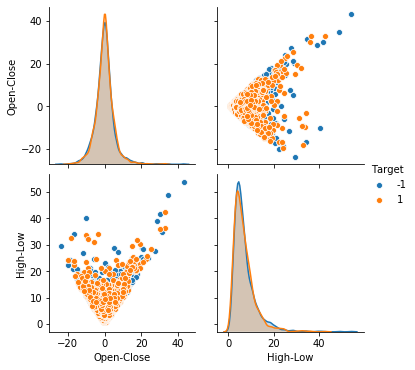

In [26]:
# Visualize for SVM
sns.pairplot(goog_data[["Open-Close","High-Low","Target"]],hue="Target")

In [27]:
# Fit the model

svc=svm.SVC()
svc.fit(X_train,Y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

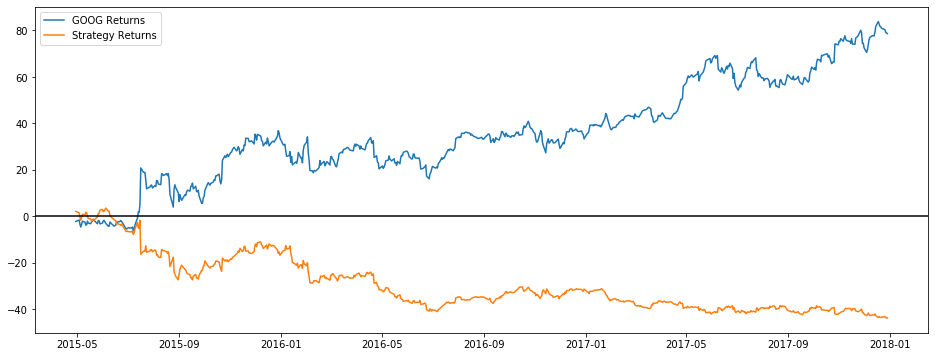

In [29]:
# Forecast Value

goog_data['Predicted_Signal']=svc.predict(X)
goog_data['GOOG_Returns']=np.log(goog_data['Close']/goog_data['Close'].shift(1))
cum_goog_return=calculate_return(goog_data,split_value=len(X_train),symbol='GOOG')
cum_strategy_return=calculate_strategy_return(goog_data,split_value=len(X_train),symbol='GOOG')
plot_chart(cum_goog_return, cum_strategy_return,symbol='GOOG')

In [30]:
print("Sharpe Ratio is: "+str(sharpe_ratio(cum_strategy_return,cum_goog_return)))

Sharpe Ratio is: -2.48511635956767
